In [5]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 9.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow==2.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 88.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 17.8 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.7.0
    Uninstalling keras-3.7.0:
      Successfully uninstalled keras-3.7.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalle

Epoch 1/350
132/132 [==============================] - 1s 6ms/step - loss: 0.8132 - accuracy: 0.6854
Epoch 2/350
132/132 [==============================] - 1s 6ms/step - loss: 0.4735 - accuracy: 0.8183
Epoch 3/350
132/132 [==============================] - 1s 6ms/step - loss: 0.4158 - accuracy: 0.8436
Epoch 4/350
132/132 [==============================] - 1s 6ms/step - loss: 0.3745 - accuracy: 0.8576
Epoch 5/350
132/132 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8679
Epoch 6/350
132/132 [==============================] - 1s 5ms/step - loss: 0.3256 - accurac

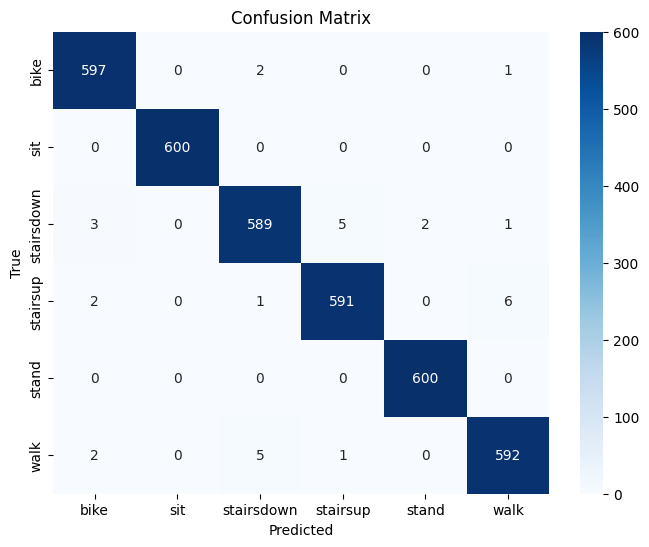

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Load dataset
data = pd.read_csv('combined_final.csv')  # Ensure your path is correct

# Extract features and target
X = data[['G1', 'G2', 'G3', 'A1', 'A2', 'A3']].values
y = data['Target']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=seed, stratify=y_encoded)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the MLP model
def build_mlp_model(input_dim, num_classes):
    model = Sequential([
        Dense(1024, input_dim=input_dim, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train MLP model
num_classes = len(label_encoder.classes_)
mlp_model = build_mlp_model(X_train.shape[1], num_classes)
mlp_model.fit(X_train, tf.keras.utils.to_categorical(y_train, num_classes), epochs=350, batch_size=64, verbose=1)

# Feature extraction with MLP
intermediate_layer_model = tf.keras.Model(inputs=mlp_model.input, outputs=mlp_model.layers[-2].output)
X_train_features = intermediate_layer_model.predict(X_train)
X_test_features = intermediate_layer_model.predict(X_test)

# Train base models
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=seed,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_features, y_train)

rf_model = RandomForestClassifier(n_estimators=300, random_state=seed)
rf_model.fit(X_train_features, y_train)

# Prepare inputs for the meta-model
xgb_train_preds = xgb_model.predict_proba(X_train_features)
rf_train_preds = rf_model.predict_proba(X_train_features)
meta_train_features = np.hstack((xgb_train_preds, rf_train_preds))

# Logistic Regression Meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=seed)
meta_model.fit(meta_train_features, y_train)

# Test set predictions
xgb_test_preds = xgb_model.predict_proba(X_test_features)
rf_test_preds = rf_model.predict_proba(X_test_features)
meta_test_features = np.hstack((xgb_test_preds, rf_test_preds))
y_pred = meta_model.predict(meta_test_features)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
